In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# gpu = 1
import torch

In [2]:
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    AutoTokenizer
)
from peft import get_peft_model, LoraConfig, TaskType, PeftModel, PeftConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import torch.nn.functional as F
from tqdm.auto import tqdm
import shutil
import re
import numpy as np
import random
import matplotlib.pyplot as plt



In [3]:
train_csv      = "/home/work/hhg/train_paragraph_balanced.csv"
test_csv      = "/home/work/.datasets/test.csv"
model_name     = "klue/roberta-base"
batch_size     = 32
learning_rate  = 1e-4
num_epochs     = 30
max_length     = 256
seed           = 42
# %%
checkpoint = "token_normal"
print(f"Checkpoint directory: {checkpoint}")

Checkpoint directory: token_normal


In [4]:
from mecab import MeCab

mecab = MeCab()

from mecab import MeCab

mecab = MeCab()

# --- 2. 커스텀 토큰 붙이기 ---
def add_custom_tokens(text):
    """
    Mecab으로 형태소 분석 후, AI/인간 텍스트 판별에 도움이 되는 품사에 커스텀 토큰 붙이기
    """
    pos_tags = mecab.pos(text)

    # 품사별 붙일 토큰 정의 (판별용으로 추려서 구성)
    target_pos = {
        # --- 어미 ---
        'EF': '_EOS',    # 종결어미
        'EC': '_CON',    # 연결어미
        'ETM': '_MOD',   # 관형형 어미

        # --- 조사 ---
        'JKS': '_SUB',   # 주격 조사
        'JKO': '_OBJ',   # 목적격 조사
        'JKB': '_ADV',   # 부사격 조사
        'JKQ': '_QUOTE', # 인용격 조사

        # --- 부사 ---
        'MAG': '_ADV',      # 일반 부사
        'MAJ': '_CONADV',   # 접속 부사

        # --- 고유명사 ---
        'NNP': '_NAME',

        # --- 문장부호 ---
        'SF': '_PUNCT',  # 마침표
        'SE': '_PUNCT',  # 물음표, 느낌표
    }

    tokens = []
    for morph, pos in pos_tags:
        if pos in target_pos:
            tokens.append(morph + target_pos[pos])
        else:
            tokens.append(morph)
    return " ".join(tokens)



In [5]:
from konlpy.tag import Okt

okt = Okt()

def normalize_text(text):
    """
    Okt 형태소 분석을 통해 동사/형용사 등을 기본형으로 변환
    """
    tokens = okt.pos(text, stem=True)  # stem=True: 동사/형용사 기본형 변환
    normalized = " ".join([word for word, tag in tokens])
    # 다중 공백을 하나로 줄이고 양쪽 공백 제거
    normalized = re.sub(r'\s+', ' ', normalized).strip()
    return normalized


In [6]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

In [7]:
# 어휘정규화에서는 공백이 아니라 삭제로 대체
# "(주어)(특수기호)는"->"(주어) 는" ->"(주어) 늘다"

def clean_text(text):
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[ㅎㅜㅠㅡ]+', '', text)
    text = re.sub(r'[\r\n]+', '', text)  
    text = re.sub(r'[^가-힣a-zA-Z0-9\s.!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [8]:
df = pd.read_csv(train_csv)
df = df.dropna(subset=['paragraph_text'])
df['paragraph_text'] = df['paragraph_text'].astype(str)
train_df, val_df = train_test_split(df,test_size=0.3,random_state=seed,stratify=df['generated'])

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # 이진 분류니까 2
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# --- AI/인간 판별용 special tokens 등록 ---
special_tokens = [
    '_EOS',     # 종결어미
    '_CON',     # 연결어미
    '_MOD',     # 관형형 어미
    '_SUB',     # 주격 조사
    '_OBJ',     # 목적격 조사
    '_ADV',     # 부사 / 부사격 조사
    '_CONADV',  # 접속 부사
    '_QUOTE',   # 인용격 조사
    '_NAME',    # 고유명사
    '_PUNCT'    # 문장부호
]

special_tokens_dict = {'additional_special_tokens': special_tokens}

# 토크나이저에 추가
tokenizer.add_special_tokens(special_tokens_dict)

# 모델 임베딩 크기 재조정
model.resize_token_embeddings(len(tokenizer))


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(32010, 768, padding_idx=1)

In [12]:
model.config.pad_token_id = model.config.eos_token_id
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05
)
model = get_peft_model(model, peft_config)
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(32010, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): Mo

In [13]:
class Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.max_length = max_length

        # special tokens 등록
        special_tokens = [
            '_EOS',     # 종결어미
            '_CON',     # 연결어미
            '_MOD',     # 관형형 어미
            '_SUB',     # 주격 조사
            '_OBJ',     # 목적격 조사
            '_ADV',     # 부사 / 부사격 조사
            '_CONADV',  # 접속 부사
            '_QUOTE',   # 인용격 조사
            '_NAME',    # 고유명사
            '_PUNCT'    # 문장부호
        ]
        special_tokens_dict = {'additional_special_tokens': special_tokens}
        self.tokenizer.add_special_tokens(special_tokens_dict)

        # ✅ 데이터 복사
        self.df = df.copy()

        # ✅ 전처리 단계 (clean → normalize → add_custom_tokens)
        self.df['processed_text'] = [
            add_custom_tokens(
                normalize_text(
                    clean_text(text)
                )
            )
            for text in tqdm(self.df['paragraph_text'], desc="Preprocessing")
        ]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        combined_text = row['processed_text']

        inputs = self.tokenizer(
            combined_text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        item = {key: val.squeeze(0) for key, val in inputs.items()}
        item['generated'] = torch.tensor(row['generated'], dtype=torch.long)

        return item


In [14]:
train_dataset = Dataset(train_df, tokenizer, max_length=max_length)
val_dataset   = Dataset(val_df, tokenizer, max_length=max_length)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Preprocessing:   0%|          | 0/140996 [00:00<?, ?it/s]

Preprocessing:   0%|          | 0/60428 [00:00<?, ?it/s]

In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import torch.nn.functional as F

def train(model, loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_preds, all_labels, all_probs = [], [], []
    progress_bar = tqdm(loader, desc="Training", leave=False)
    
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['generated'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0.5
    f1 = f1_score(all_labels, all_preds, average="macro")
    
    return avg_loss, acc, auc, f1, all_preds, all_labels


In [16]:
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels, all_probs = [], [], []
    progress_bar = tqdm(loader, desc="Validation", leave=False)
    
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['generated'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            total_loss += outputs.loss.item()
            logits = outputs.logits
            probs = F.softmax(logits, dim=1)[:, 1]
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            progress_bar.set_postfix(loss=f"{outputs.loss.item():.4f}")
    
    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0.5
    f1 = f1_score(all_labels, all_preds, average="macro")
    
    return avg_loss, acc, auc, f1, all_preds, all_labels

In [17]:
from sklearn.metrics import f1_score

def train_model(model, model_name, tokenizer, train_loader, val_loader, num_epochs, learning_rate, checkpoint):
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )
    
    if not os.path.exists(checkpoint):
        os.makedirs(checkpoint)

    best_auc = 0.0
    train_losses, train_aucs, train_f1s = [], [], []
    val_losses, val_aucs, val_accs, val_f1s = [], [], [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loss, train_acc, train_auc, train_f1, train_preds, train_labels = train(model, train_loader, optimizer, scheduler, device)
        val_loss, val_acc, val_auc, val_f1, val_preds, val_labels = evaluate(model, val_loader, device)
        
        train_losses.append(train_loss)
        train_aucs.append(train_auc)
        train_f1s.append(train_f1)

        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)
        
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train AUC: {train_auc:.4f} | Train F1: {train_f1:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f} | Val F1: {val_f1:.4f}")

        adapter_ckpt = os.path.join(checkpoint, f"epoch{epoch+1}_auc{val_auc:.4f}")
        model.save_pretrained(adapter_ckpt)
        tokenizer.save_pretrained(adapter_ckpt)

        if val_auc > best_auc:
            best_auc = val_auc
            model.save_pretrained(os.path.join(checkpoint, "best_model"))
            tokenizer.save_pretrained(os.path.join(checkpoint, "best_model"))
            print(f"Best model saved: {adapter_ckpt}")

    # 손실, AUC, Accuracy, F1 곡선 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")

    ax2 = plt.gca().twinx()
    ax2.plot(train_aucs, label="Train AUC", color='blue')
    ax2.plot(val_aucs, label="Validation AUC", color='green')
    ax2.plot(val_accs, label="Validation Accuracy", color='orange')
    ax2.plot(val_f1s, label="Validation F1", color='red')
    ax2.set_ylabel("AUC / Accuracy / F1")
    ax2.legend(loc="upper right")

    plt.title("Loss, AUC, Accuracy, and F1 per Epoch")
    plt.grid(True)
    plt.show()

    torch.cuda.empty_cache()

In [18]:
# checkpoint_dir = f"{checkpoin}/epoch3_auc0.9985"  # ← 실제 디렉토리로 변경 필요

# model = AutoModelForSequenceClassification.from_pretrained(checkpoint_dir).to(device)
# tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)

model_name: klue/roberta-base
Checkpoint directory: token_normal
learning_rate: 0.0001
Using device: cuda
Epoch 1/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.6507 | Train Acc: 0.5992 | Train AUC: 0.6370 | Train F1: 0.5947
Val   Loss: 0.6265 | Val   Acc: 0.6294 | Val AUC: 0.6809 | Val F1: 0.6284


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: token_normal/epoch1_auc0.6809
Epoch 2/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.6123 | Train Acc: 0.6401 | Train AUC: 0.6805 | Train F1: 0.6277
Val   Loss: 0.6577 | Val   Acc: 0.6118 | Val AUC: 0.6915 | Val F1: 0.6083


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: token_normal/epoch2_auc0.6915
Epoch 3/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.6016 | Train Acc: 0.6506 | Train AUC: 0.6926 | Train F1: 0.6378
Val   Loss: 0.6315 | Val   Acc: 0.6397 | Val AUC: 0.6998 | Val F1: 0.6395


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: token_normal/epoch3_auc0.6998
Epoch 4/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5930 | Train Acc: 0.6604 | Train AUC: 0.7033 | Train F1: 0.6482
Val   Loss: 0.6526 | Val   Acc: 0.6298 | Val AUC: 0.7015 | Val F1: 0.6294


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: token_normal/epoch4_auc0.7015
Epoch 5/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5862 | Train Acc: 0.6674 | Train AUC: 0.7110 | Train F1: 0.6557
Val   Loss: 0.6196 | Val   Acc: 0.6466 | Val AUC: 0.7107 | Val F1: 0.6464


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: token_normal/epoch5_auc0.7107
Epoch 6/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5807 | Train Acc: 0.6724 | Train AUC: 0.7163 | Train F1: 0.6606
Val   Loss: 0.6171 | Val   Acc: 0.6453 | Val AUC: 0.7128 | Val F1: 0.6453


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: token_normal/epoch6_auc0.7128
Epoch 7/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5753 | Train Acc: 0.6765 | Train AUC: 0.7233 | Train F1: 0.6653
Val   Loss: 0.6475 | Val   Acc: 0.6411 | Val AUC: 0.7134 | Val F1: 0.6410


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: token_normal/epoch7_auc0.7134
Epoch 8/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5704 | Train Acc: 0.6812 | Train AUC: 0.7279 | Train F1: 0.6702
Val   Loss: 0.7033 | Val   Acc: 0.6125 | Val AUC: 0.7128 | Val F1: 0.6043


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 9/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5651 | Train Acc: 0.6862 | Train AUC: 0.7347 | Train F1: 0.6755
Val   Loss: 0.6573 | Val   Acc: 0.6443 | Val AUC: 0.7169 | Val F1: 0.6441


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: token_normal/epoch9_auc0.7169
Epoch 10/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5608 | Train Acc: 0.6913 | Train AUC: 0.7395 | Train F1: 0.6811
Val   Loss: 0.6469 | Val   Acc: 0.6475 | Val AUC: 0.7169 | Val F1: 0.6475


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: token_normal/epoch10_auc0.7169
Epoch 11/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5563 | Train Acc: 0.6945 | Train AUC: 0.7453 | Train F1: 0.6848
Val   Loss: 0.6772 | Val   Acc: 0.6370 | Val AUC: 0.7193 | Val F1: 0.6358


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: token_normal/epoch11_auc0.7193
Epoch 12/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5516 | Train Acc: 0.6985 | Train AUC: 0.7501 | Train F1: 0.6893
Val   Loss: 0.6730 | Val   Acc: 0.6473 | Val AUC: 0.7183 | Val F1: 0.6473


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 13/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5473 | Train Acc: 0.7024 | Train AUC: 0.7552 | Train F1: 0.6935
Val   Loss: 0.6959 | Val   Acc: 0.6486 | Val AUC: 0.7178 | Val F1: 0.6486


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 14/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5445 | Train Acc: 0.7045 | Train AUC: 0.7587 | Train F1: 0.6957
Val   Loss: 0.7421 | Val   Acc: 0.6325 | Val AUC: 0.7179 | Val F1: 0.6304


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 15/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5393 | Train Acc: 0.7094 | Train AUC: 0.7641 | Train F1: 0.7011
Val   Loss: 0.7073 | Val   Acc: 0.6428 | Val AUC: 0.7217 | Val F1: 0.6422


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: token_normal/epoch15_auc0.7217
Epoch 16/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5363 | Train Acc: 0.7112 | Train AUC: 0.7664 | Train F1: 0.7027
Val   Loss: 0.7537 | Val   Acc: 0.6288 | Val AUC: 0.7216 | Val F1: 0.6251


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 17/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5326 | Train Acc: 0.7155 | Train AUC: 0.7713 | Train F1: 0.7077
Val   Loss: 0.7123 | Val   Acc: 0.6463 | Val AUC: 0.7219 | Val F1: 0.6460


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: token_normal/epoch17_auc0.7219
Epoch 18/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5307 | Train Acc: 0.7160 | Train AUC: 0.7735 | Train F1: 0.7084
Val   Loss: 0.6902 | Val   Acc: 0.6489 | Val AUC: 0.7235 | Val F1: 0.6487


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: token_normal/epoch18_auc0.7235
Epoch 19/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5276 | Train Acc: 0.7204 | Train AUC: 0.7769 | Train F1: 0.7129
Val   Loss: 0.7607 | Val   Acc: 0.6380 | Val AUC: 0.7227 | Val F1: 0.6365


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 20/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5227 | Train Acc: 0.7227 | Train AUC: 0.7816 | Train F1: 0.7155
Val   Loss: 0.7452 | Val   Acc: 0.6407 | Val AUC: 0.7244 | Val F1: 0.6391


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: token_normal/epoch20_auc0.7244
Epoch 21/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5205 | Train Acc: 0.7241 | Train AUC: 0.7845 | Train F1: 0.7172
Val   Loss: 0.7713 | Val   Acc: 0.6341 | Val AUC: 0.7233 | Val F1: 0.6315


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 22/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5173 | Train Acc: 0.7270 | Train AUC: 0.7872 | Train F1: 0.7203
Val   Loss: 0.8075 | Val   Acc: 0.6361 | Val AUC: 0.7237 | Val F1: 0.6337


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 23/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5141 | Train Acc: 0.7311 | Train AUC: 0.7907 | Train F1: 0.7246
Val   Loss: 0.7874 | Val   Acc: 0.6381 | Val AUC: 0.7241 | Val F1: 0.6363


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 24/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5134 | Train Acc: 0.7296 | Train AUC: 0.7915 | Train F1: 0.7232
Val   Loss: 0.7514 | Val   Acc: 0.6478 | Val AUC: 0.7252 | Val F1: 0.6473


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: token_normal/epoch24_auc0.7252
Epoch 25/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5113 | Train Acc: 0.7324 | Train AUC: 0.7931 | Train F1: 0.7261
Val   Loss: 0.7863 | Val   Acc: 0.6381 | Val AUC: 0.7253 | Val F1: 0.6359


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: token_normal/epoch25_auc0.7253
Epoch 26/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5081 | Train Acc: 0.7347 | Train AUC: 0.7964 | Train F1: 0.7286
Val   Loss: 0.8076 | Val   Acc: 0.6376 | Val AUC: 0.7237 | Val F1: 0.6355


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 27/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5072 | Train Acc: 0.7345 | Train AUC: 0.7973 | Train F1: 0.7283
Val   Loss: 0.8263 | Val   Acc: 0.6361 | Val AUC: 0.7247 | Val F1: 0.6336


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 28/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5057 | Train Acc: 0.7361 | Train AUC: 0.7988 | Train F1: 0.7300
Val   Loss: 0.7868 | Val   Acc: 0.6405 | Val AUC: 0.7250 | Val F1: 0.6390


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 29/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5038 | Train Acc: 0.7374 | Train AUC: 0.8006 | Train F1: 0.7315
Val   Loss: 0.8075 | Val   Acc: 0.6386 | Val AUC: 0.7252 | Val F1: 0.6367


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 30/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5036 | Train Acc: 0.7373 | Train AUC: 0.8014 | Train F1: 0.7314
Val   Loss: 0.8124 | Val   Acc: 0.6387 | Val AUC: 0.7247 | Val F1: 0.6367


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


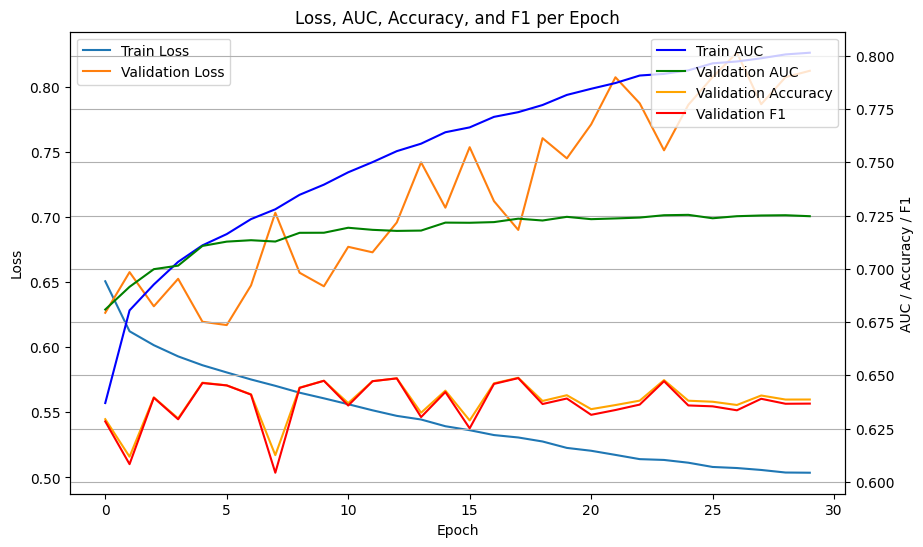

In [19]:
print(f"model_name: {model_name}")
print(f"Checkpoint directory: {checkpoint}")
print(f"learning_rate: {learning_rate}")

# 디바이스 재확인 및 모델 디바이스 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
print(f"Using device: {device}")

# train_model 호출
train_model(
    model,
    model_name,
    tokenizer,
    train_loader,
    val_loader,
    num_epochs,
    learning_rate,
    checkpoint
)

In [20]:
def predict(model, loader, device):
    model.eval()
    preds, probs = [], []
    bar = tqdm(loader, desc="Predicting", leave=False)
    with torch.no_grad():
        for batch in bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            prob = F.softmax(logits, dim=1)[:, 1]  # positive 확률

            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            probs.extend(prob.detach().float().cpu().numpy())  # bfloat16 → float32로 변환 후 numpy
    return preds, probs

In [23]:
import torch
from torch.utils.data import Dataset

class TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

        # --- special tokens 등록 (AI/인간 판별용 확장 세트) ---
        special_tokens = [
            '_EOS',     # 종결어미
            '_CON',     # 연결어미
            '_MOD',     # 관형형 어미
            '_SUB',     # 주격 조사
            '_OBJ',     # 목적격 조사
            '_ADV',     # 부사 / 부사격 조사
            '_CONADV',  # 접속 부사
            '_QUOTE',   # 인용격 조사
            '_NAME',    # 고유명사
            '_PUNCT'    # 문장부호
        ]
        special_tokens_dict = {'additional_special_tokens': special_tokens}
        self.tokenizer.add_special_tokens(special_tokens_dict)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        text = row['paragraph_text']
        title = row['title']  # 타이틀 열

        # --- 텍스트 전처리 ---
        text = clean_text(text)
        
        text = normalize_text(text)
        text = add_custom_tokens(text)  # 품사 기반 커스텀 토큰 부착

        # --- 타이틀 + 본문 결합 ---
        combined_text = f"[TITLE] {title} [SEP] {text}"

        # --- 토큰화 ---
        encoding = self.tokenizer(
            combined_text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors="pt"
        )

        return {
            'input_ids':      encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }


In [24]:
test_df = pd.read_csv(test_csv)
test_dataset  = TestDataset(test_df, tokenizer, max_length=max_length)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [25]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer

def load_lora_model(adapter_path, torch_dtype=None):
    """
    LoRA adapter 경로로부터 base model과 tokenizer를 로드하고,
    LoRA adapter를 적용한 모델과 tokenizer 반환.

    Args:
        adapter_path (str): 저장된 LoRA adapter 디렉토리 경로
        torch_dtype (torch.dtype, optional): 모델 로드 시 사용할 dtype (예: torch.bfloat16)

    Returns:
        model (PeftModel): LoRA adapter가 적용된 모델
        tokenizer (AutoTokenizer): 저장된 tokenizer
    """
    # 1. adapter config 로드
    peft_config = PeftConfig.from_pretrained(adapter_path, local_files_only=True)

    # 2. tokenizer 먼저 adapter_path에서 로드
    tokenizer = AutoTokenizer.from_pretrained(adapter_path, use_fast=True)

    # 2. base model 로드
    base_model = AutoModelForSequenceClassification.from_pretrained(
        peft_config.base_model_name_or_path,
        torch_dtype=torch_dtype
    )
    base_model.config.pad_token_id = base_model.config.eos_token_id

    # 4. tokenizer 사이즈에 맞게 임베딩 resize
    base_model.resize_token_embeddings(len(tokenizer))

    # 3. LoRA adapter 적용
    model = PeftModel.from_pretrained(base_model, adapter_path)

    return model, tokenizer


In [26]:
load_path = f"{checkpoint}/best_model"
model, tokenizer = load_lora_model(load_path, torch_dtype=torch.bfloat16)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

pred_labels, pred_probs = predict(model, test_loader, device)

sample_submission = pd.read_csv('/home/work/.datasets/sample_submission.csv', encoding='utf-8-sig')

# 확률로 저장
sample_submission_probs = sample_submission.copy()
sample_submission_probs['generated'] = pred_probs

# 저장 디렉토리
output_dir = f"/home/work/hhg/{checkpoint}"

output_path = os.path.join(output_dir, f"{checkpoint}_best.csv")
sample_submission_probs.to_csv(output_path, index=False)

print(f"파일이 저장되었습니다: {output_path}")


Predicting:   0%|          | 0/62 [00:00<?, ?it/s]

파일이 저장되었습니다: /home/work/hhg/token_normal/token_normal_best.csv
